In [237]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [238]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('cork_property_prices*.csv')], ignore_index = True)

In [239]:
print("Number of rows before dedupes:,", len(df))
df = df.drop_duplicates(subset='listing_id', keep='last') # Dedup on listing_id and keep first record.
print("Number of rows after dedupes:,", len(df))
print("Number of unique properties: ", df.listing_id.nunique())

Number of rows before dedupes:, 257
Number of rows after dedupes:, 257
Number of unique properties:  257


In [240]:
# Clean data
df['cost'] = df['cost'].str.replace(",","") # Remove commas in cost column
df = df[(df.cost.str.isnumeric() == True)] # Remove rows with alpha characters
df['cost'] = pd.to_numeric(df['cost'])
df['cost'] = df['cost']/1000

# Create an ordinal equivalent of BER
df['ber'] = pd.Categorical(df['ber'])
df['ber_ord'] = df.ber.cat.codes

In [241]:
#df
#df.describe()
#df.shape
#df.info()
df = df[(df.floor_area.notnull()) & (df.floor_area < 500)]
#print(len(df))

In [242]:
df

,listing_id,url,location,address,beds,bathrooms,cost,num_pics,property_type,ber,eircode,floor_area,ber_ord
0,2162034,/cork/houses-for-sale/douglas/no-1-elmbank-dou...,douglas,No 1 Elmbank| Douglas Road| Douglas| Co. Cork,6,3,575.0,24,Terraced House,C2,T12 Y1X3,278.70,6
2,2578874,/cork/houses-for-sale/douglas/35-grange-vale-p...,douglas,35 Grange Vale| Pinecroft| Douglas| Co. Cork,3,1,250.0,48,Semi-Detached House,D2,T12 P7FV,80.00,9
3,2549821,/cork/houses-for-sale/douglas/70-welwyn-road-m...,douglas,70 Welwyn Road| Maryborough Woods| Douglas| Co...,3,3,289.0,12,Semi-Detached House,C2,T12 XAC8,107.60,6
4,2549894,/cork/houses-for-sale/douglas/kincora-south-do...,douglas,Kincora| South Douglas Road| Douglas| Co. Cork,3,1,259.0,24,Semi-Detached House,NaN,T12 Y6C7,99.50,-1
5,2255069,/cork/houses-for-sale/douglas/denmead-38-hetty...,douglas,Denmead| 38 Hettyfield Park| Douglas| Co. Cork,4,4,795.0,23,Detached House,D1,NaN,200.02,8
6,2217312,/cork/houses-for-sale/douglas/80-yewlands-mary...,douglas,80 Yewlands| Maryborough Woods| Douglas| Co. Cork,3,3,310.0,8,Terraced House,C1,T12 PWT7,111.90,5
7,2548380,/cork/houses-for-sale/douglas/115-greenhills-c...,douglas,115 Greenhills Court| South Douglas Road| Doug...,3,2,245.0,33,Terraced House,C3,T12 FXY5,95.50,7
9,2602802,/cork/houses-for-sale/douglas/20-the-paddocks-...,douglas,20 The Paddocks| Maryborough Hill| Douglas| Co...,6,3,670.0,27,Detached House,C2,T12 HN4C,202.00,6
10,2600677,/cork/houses-for-sale/douglas/1-well-road-home...,douglas,1 Well Road Homes| Churchyard Lane| Douglas| C...,2,2,250.0,18,End of Terrace House,NaN,T12 F1HT,74.30,-1
11,2593331,/cork/houses-for-sale/douglas/saint-josephs-50...,douglas,Saint Josephs| 50 Grange Way| Pinecroft| Dougl...,2,1,250.0,17,Semi-Detached House,E1,T12 T8X5,81.20,10


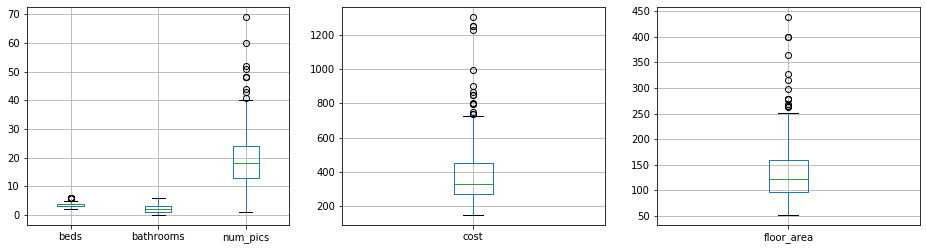

In [243]:
plt.rcParams['figure.figsize'] = [16, 4]
plt.tight_layout()
plt.subplot(1, 3, 1)
pd.DataFrame(df,columns=["beds","bathrooms","num_pics"]).boxplot()
plt.subplot(1, 3, 2)
pd.DataFrame(df,columns=["cost"]).boxplot()
plt.subplot(1, 3, 3)
pd.DataFrame(df,columns=["floor_area"]).boxplot()

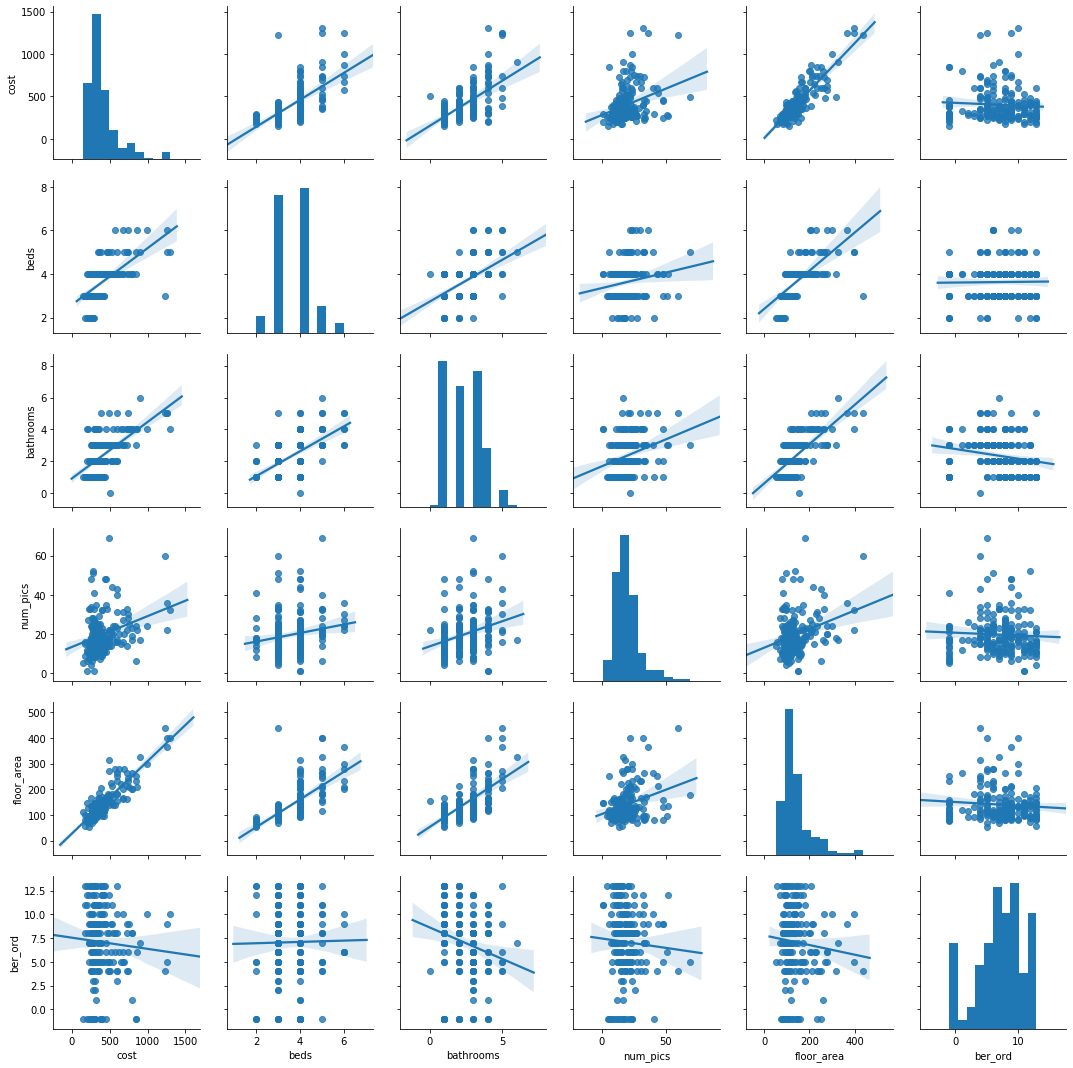

In [244]:
# Basic correlogram
sns.pairplot(df
             ,vars=["cost", "beds", "bathrooms", "num_pics","floor_area","ber_ord"]
             ,kind="reg"
             #,hue="property_type"
            )
plt.show()

In [245]:
# Explore data by location
#df.plot.line(data=df["beds","cost"], x="beds", y="cost")
#df[["beds","cost","location"]].groupby('location','beds').plot(x="beds", y="cost")
df.groupby(['location', 'beds'])['cost'].agg(['count','mean'])
filter1 = df['property_type']=='Semi-Detached House'
#filter2 = df['location'].isin(['douglas','model-farm-road','bishopstown','blackrock','glasheen'])
filter3 = df['beds']==3
filtered = df[filter1 & filter3]
filtered.groupby(['location','property_type','beds'])['cost'].agg(['count','mean']).sort_values('mean',ascending=False)


,,,count,mean
location,property_type,beds,,
model-farm-road,Semi-Detached House,3,2,385.000000
ballintemple,Semi-Detached House,3,4,342.500000
bishopstown,Semi-Detached House,3,2,342.500000
blackrock,Semi-Detached House,3,3,330.000000
rochestown,Semi-Detached House,3,5,328.000000
glasheen,Semi-Detached House,3,6,316.500000
ballinlough,Semi-Detached House,3,5,303.000000
lehenaghmore,Semi-Detached House,3,4,281.250000
douglas,Semi-Detached House,3,12,278.916667


## Feature Engineering
The data needs some manipulation to be optimal for modeling. Changes we'll make:

1. 1-hot encode categorical variables for use in linear models.
2. Create a continuous equivalent of the BER categorical variable. 
3. Create a binary variable that indicates if the house is named or numbers. Intuition is that numbered houses are less valuable.


In [246]:
# Create 1-hot encodings for property_type and location variables.
loc_vars = pd.get_dummies(df.location, prefix = 'loc')
type_vars = pd.get_dummies(df.property_type, prefix = 'type')
df = pd.concat([df,loc_vars,type_vars], axis=1)
df.shape

(196, 31)

In [247]:
df.ber.isnull().describe()

count       196
unique        2
top       False
freq        176
Name: ber, dtype: object

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 256
Data columns (total 31 columns):
listing_id                   196 non-null int64
url                          196 non-null object
location                     196 non-null object
address                      193 non-null object
beds                         196 non-null int64
bathrooms                    196 non-null int64
cost                         196 non-null float64
num_pics                     196 non-null int64
property_type                196 non-null object
ber                          176 non-null category
eircode                      182 non-null object
floor_area                   196 non-null float64
ber_ord                      196 non-null int8
loc_ballincollig             196 non-null uint8
loc_ballinlough              196 non-null uint8
loc_ballintemple             196 non-null uint8
loc_bishopstown              196 non-null uint8
loc_blackrock                196 non-null uint8
loc_carrigaline     

In [249]:
# 75:25 train:test split.
from sklearn.model_selection import train_test_split
prepped_data = df.drop(['listing_id','url','location','address','property_type','ber','eircode'], axis=1)
train, test = train_test_split(prepped_data, test_size=0.2)
x = train.drop('cost', axis=1)
y = train.cost
x = prepped_data.drop('cost', axis=1)
y = prepped_data.cost
# Train model
reg = linear_model.LinearRegression()
#x = train[['beds','bathrooms','num_pics','ber_ord']]
#x = train.drop()
#y = train['cost']
reg.fit(x,y)
print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 27.73167535160394
Coefficients: 
 [   9.70428519    6.73096294    0.59161388    2.2566431    -1.56884474
  -54.95779603  -23.16069824   52.37472042   -3.40596265   36.3300009
 -102.11295885   18.14579085   19.85675761   -7.98719801  -37.61629756
   50.76431497    6.82495242   44.94437418   62.04811625   16.78701103
   12.56337178  -74.27965617  -17.11884288]


In [250]:
y_true = test.cost
y_pred = reg.predict(test.drop('cost', axis=1))
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: %f" % (rmse))
print("MSE: ", mean_squared_error(y_true, y_pred))
print("Mean Absolute Error: %f" % mean_absolute_error(y_true,y_pred))
print("R2: ", r2_score(y_true,y_pred))

RMSE: 67.370106
MSE:  4538.731207003299
Mean Absolute Error: 50.332424
R2:  0.8994724868027292


In [256]:
# Train model on full data set and assess
x = prepped_data.drop('cost', axis=1)
y = prepped_data.cost
full_reg = linear_model.LinearRegression()
full_reg.fit(x,y)
y_true = prepped_data.cost
y_pred = full_reg.predict(prepped_data.drop('cost', axis=1))
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: %f" % (rmse))
print("MSE: ", mean_squared_error(y_true, y_pred))
print("Mean Absolute Error: %f" % mean_absolute_error(y_true,y_pred))
print("R2: ", r2_score(y_true,y_pred))

RMSE: 74.893640
MSE:  5609.057278602681
Mean Absolute Error: 56.315396
R2:  0.8642783369115545


In [261]:
#output = pd.concat([prepped_data, y_pred], axis=1)
#output
prepped_data['output'] = y_pred
prepped_data

,beds,bathrooms,cost,num_pics,floor_area,ber_ord,loc_ballincollig,loc_ballinlough,loc_ballintemple,loc_bishopstown,...,loc_lehenaghmore,loc_model-farm-road,loc_rochestown,loc_wilton,type_Detached House,type_End of Terrace House,type_Semi-Detached House,type_Terraced House,type_Townhouse,output
0,6,3,575.0,24,278.70,6,0,0,0,0,...,0,0,0,0,0,0,0,1,0,685.439472
2,3,1,250.0,48,80.00,9,0,0,0,0,...,0,0,0,0,0,0,1,0,0,290.804935
3,3,3,289.0,12,107.60,6,0,0,0,0,...,0,0,0,0,0,0,1,0,0,349.958644
4,3,1,259.0,24,99.50,-1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,336.299189
5,4,4,795.0,23,200.02,8,0,0,0,0,...,0,0,0,0,1,0,0,0,0,627.807655
6,3,3,310.0,8,111.90,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,272.021571
7,3,2,245.0,33,95.50,7,0,0,0,0,...,0,0,0,0,0,0,0,1,0,239.934319
9,6,3,670.0,27,202.00,6,0,0,0,0,...,0,0,0,0,1,0,0,0,0,650.457561
10,2,2,250.0,18,74.30,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,277.132417
11,2,1,250.0,17,81.20,10,0,0,0,0,...,0,0,0,0,0,0,1,0,0,263.899746


In [262]:
dir(full_reg)
coeff_df = pd.DataFrame(full_reg.coef_, x.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
beds,9.704285
bathrooms,6.730963
num_pics,0.591614
floor_area,2.256643
ber_ord,-1.568845
loc_ballincollig,-54.957796
loc_ballinlough,-23.160698
loc_ballintemple,52.374720
loc_bishopstown,-3.405963
loc_blackrock,36.330001


In [265]:
num_vars = df[['beds','bathrooms','num_pics','floor_area','loc_model-farm-road']]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(num_vars.values, i) for i in range(num_vars.shape[1])]
vif["features"] = num_vars.columns
vif

,VIF Factor,features
0,12.898141,beds
1,9.614983,bathrooms
2,4.811422,num_pics
3,13.881966,floor_area
4,1.080141,loc_model-farm-road


In [ ]:
# For analysis purpose run entire set through linear model
x = df.drop('cost', axis=1)
y = df.cost

reg = linear_model.LinearRegression()
reg.fit(x,y)
coeff_df = pd.DataFrame(reg.coef_, x.columns, columns=['Coefficient'])  

print('Intercept: \n', reg.intercept_)
coeff_df